In [1]:
import yfinance as yf
import yfinance as yf
import pandas as pd
# Define the ticker symbol for Bank of India (BOI)
ticker = "YESBANK.NS"  # This is the ticker for Bank of India on the NSE

# Fetch historical data for the past 7 years
data = yf.download(ticker, start="2013-11-06", end="2020-06-12" )

# Display the first few rows of the data
print(data.head())
data.to_csv('BOI_7_years_data.csv')
df=pd.read_csv('BOI_7_years_data.csv')
df = df.drop([0,1])
df.to_csv('New file.csv')

data=pd.read_csv('New file.csv')
print(data.head())
print(data.tail())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker     YESBANK.NS YESBANK.NS YESBANK.NS YESBANK.NS YESBANK.NS
Date                                                             
2013-11-06  68.182678  69.848382  67.386843  69.348671   31461630
2013-11-07  66.766830  69.394932  66.544739  68.663874   34542345
2013-11-08  65.563820  67.627441  65.221430  67.118474   40878305
2013-11-11  61.714207  65.313970  61.399571  65.008590   47216800
2013-11-12  60.881359  63.389163  60.298366  61.973319   34123545
   Unnamed: 0       Price      Close       High        Low       Open  \
0           2  2013-11-06  68.182678  69.848382  67.386843  69.348671   
1           3  2013-11-07  66.766830  69.394932  66.544739  68.663874   
2           4  2013-11-08  65.563820  67.627441  65.221430  67.118474   
3           5  2013-11-11  61.714207  65.313970  61.399571  65.008590   
4           6  2013-11-12  60.881359  63.389163  60.298366  61.973319   

     Volume  
0  31461630  
1  34

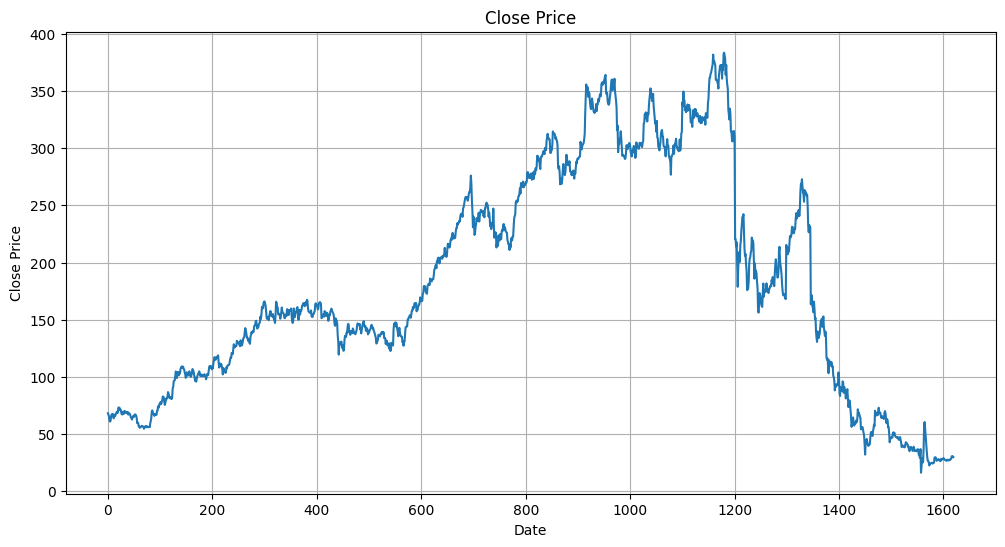

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Data Preprocessing
data = pd.read_csv('New file.csv')
X = data[['Open', 'High', 'Low', 'Close']]
y = data['Close']

print(X.shape)
print(y.shape)

(1620, 4)
(1620,)


In [5]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Save the dates before splitting




'''X_train=X_scaled[:-5]
y_train=X_scaled[-5:]
X_test=X_scaled[-5:]
y_test=X_scaled[-5:]
'''
X_train, X_test, y_train, y_test,  = train_test_split(
    X_scaled, y,  test_size=0.1, shuffle=False
)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train)
print("**********")
print(y_test)

(1458, 4)
(1458,)
(162, 4)
(162,)
0       68.182678
1       66.766830
2       65.563820
3       61.714207
4       60.881359
          ...    
1453    45.650002
1454    43.250000
1455    40.950001
1456    39.599998
1457    40.099998
Name: Close, Length: 1458, dtype: float64
**********
1458    40.599998
1459    41.049999
1460    47.400002
1461    51.400002
1462    51.799999
          ...    
1615    28.850000
1616    30.600000
1617    29.850000
1618    30.400000
1619    29.799999
Name: Close, Length: 162, dtype: float64


In [6]:
# Step 2: Stacked Autoencoder (SAE)
input_dim = X_train.shape[1]
print(input_dim)
encoding_dim = 32

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=1, batch_size=32, shuffle=False, validation_data=(X_test, X_test))

encoder = models.Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)
type( X_train_encoded)

4
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0699 - val_loss: 0.1844
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


numpy.ndarray

In [7]:
# Step 3: Kernel Extreme Learning Machine (KELM)
def polynomial_kernel(X, Y, degree=3, coef0=1):
    return (np.dot(X, Y.T) + coef0) ** degree

def rbf_kernel(X, Y, gamma=0.1):
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    return np.exp(-gamma * np.linalg.norm(X[:, np.newaxis] - Y, axis=2) ** 2)

def sigmoid_kernel(X, Y, coef0=1, gamma=0.1):
    return np.tanh(gamma * np.dot(X, Y.T) + coef0)

class KELM:
    def __init__(self, kernel='rbf', C=1.0, degree=3, gamma=None, coef0=1):
        self.C = C
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.kernel = kernel
        self.alpha_ = None

    def _compute_kernel(self, X, Y):
        if self.kernel == 'polynomial':
            return polynomial_kernel(X, Y, self.degree, self.coef0)
        elif self.kernel == 'rbf':
            return rbf_kernel(X, Y, self.gamma)
        elif self.kernel == 'sigmoid':
            return sigmoid_kernel(X, Y, self.coef0, self.gamma)
        else:
            raise ValueError("Unsupported kernel type")

    def fit(self, X, y):
        y=np.array(y,dtype=float)

        K = self._compute_kernel(X, X)
        N = K.shape[0]
        I = np.identity(N)
        self.alpha_ = np.linalg.inv(I / self.C + K).dot(y)
        self.X_train_ = X

    def predict(self, X):
        K_test = self._compute_kernel(X, self.X_train_)
        return K_test.dot(self.alpha_)

In [8]:
kelm = KELM(kernel='polynomial', C=1.0, gamma=0.1)
kelm.fit(X_train_encoded, y_train)
y_pred = kelm.predict(X_test_encoded)

In [9]:
# Step 4: Evaluation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true=y_true.astype(float)
    y_pred=y_pred.astype(float)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)


print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

MAPE: 15.73%
MAE: 5.0017
RMSE: 5.5854
R-squared: 0.8446


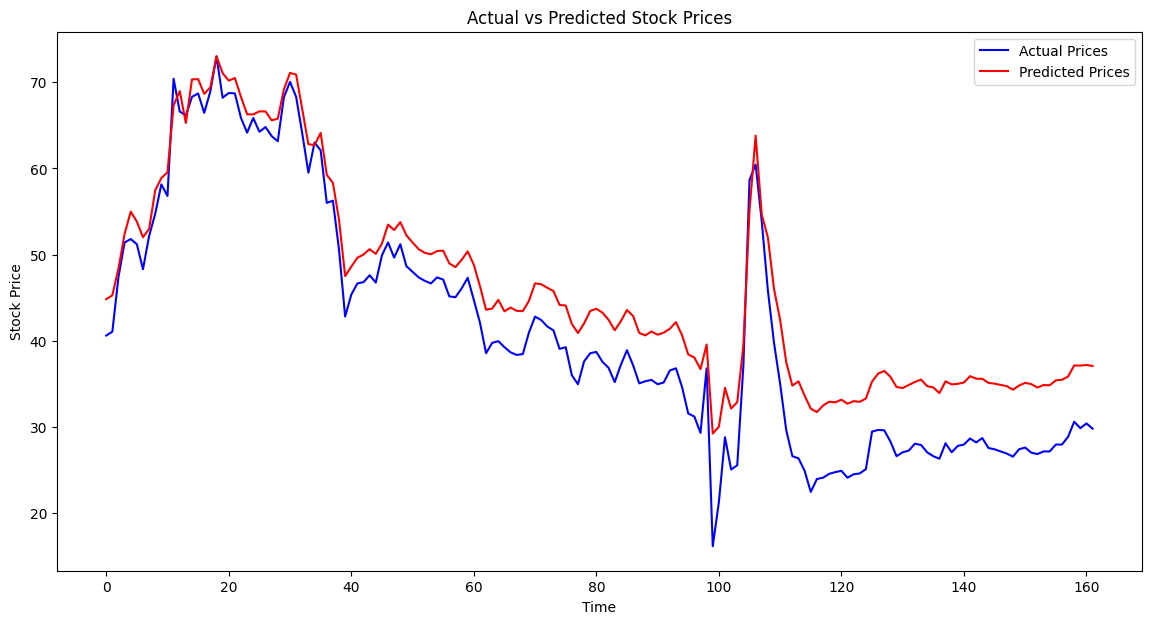

In [10]:
# Step 5: Visualization
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


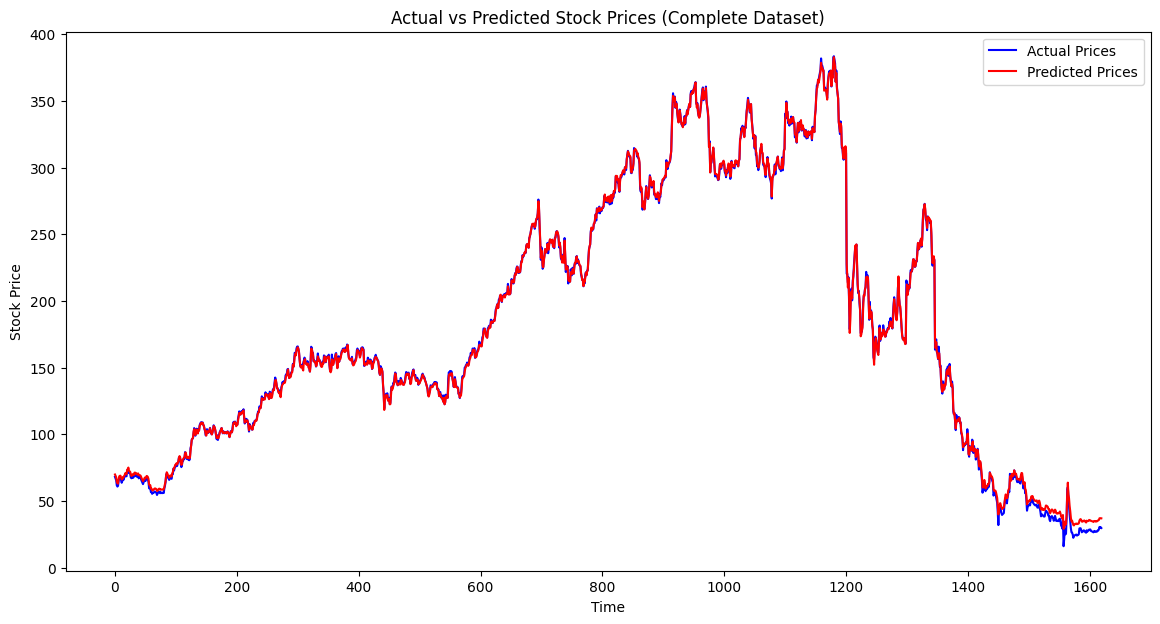

In [11]:
import matplotlib.pyplot as plt
# Get predictions for the entire dataset
X_scaled_all = scaler.transform(X)
X_encoded_all = encoder.predict(X_scaled_all)
y_pred_all = kelm.predict(X_encoded_all)

# Plot the actual and predicted values for the entire dataset
plt.figure(figsize=(14, 7))
plt.plot(y.values, label='Actual Prices', color='blue')
plt.plot(y_pred_all, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (Complete Dataset)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [12]:

# Function to generate Buy/Sell signals
def get_buy_sell_signals(actual_prices, predicted_prices):
    signals = []
    for i in range(len(actual_prices)):
        if predicted_prices[i] > actual_prices[i]:
            signals.append(f"Buy {predicted_prices[i]} {actual_prices[i]}")
        elif predicted_prices[i] < actual_prices[i]:
            signals.append(f"Sell {predicted_prices[i]} {actual_prices[i]}")

    return signals

# Generate the Buy/Sell signals using actual and predicted prices
signals = get_buy_sell_signals(y_test.values, y_pred)
print(signals[:15])  # Show the first 10 Buy/Sell signals


['Buy 44.823747064405794 40.59999847412109', 'Buy 45.270425879008286 41.04999923706055', 'Buy 48.39005027280146 47.400001525878906', 'Buy 52.40304465183755 51.400001525878906', 'Buy 54.9806239967382 51.79999923706055', 'Buy 53.83309754117242 51.20000076293945', 'Buy 52.00993638327416 48.29999923706055', 'Buy 52.97758972827443 52.150001525878906', 'Buy 57.459871370558815 54.75', 'Buy 58.88307019113854 58.150001525878906', 'Buy 59.55601302374118 56.79999923706055', 'Sell 67.3360448451034 70.4000015258789', 'Buy 68.96991500299615 66.5999984741211', 'Sell 65.27818243781647 66.1500015258789', 'Buy 70.33485335977159 68.30000305175781']


In [ ]:
print(y_test.values.shape)
print(y_pred.shape)

(173,)
(173,)


In [13]:
# Function to compute strategy returns
def compute_strategy_returns(actual_prices, predicted_prices, Bc, Sc):
    returns = 0
    for t in range(len(actual_prices) - 1):
        if predicted_prices[t + 1] > actual_prices[t]:  # Buy signal
            returns += (predicted_prices[t + 1] - actual_prices[t] + (actual_prices[t] * Bc + predicted_prices[t + 1] * Sc)) / actual_prices[t]
        else:  # Sell signal
            returns += (actual_prices[t] - predicted_prices[t + 1] + (predicted_prices[t + 1] * Bc + actual_prices[t] * Sc)) / actual_prices[t]
    return 100 * returns

# Compute strategy returns
strategy_returns = compute_strategy_returns(y_test.values, y_pred, Bc=0.001, Sc=0.001)
print("Strategy Returns:", strategy_returns)

Strategy Returns: 2663.7399767673323
